# 実験を開始する

実験パッケージを用意して実験の開始をサポートします。  
上から順番に実行してください。  
2回目以降の実行では、画面上部に表示される以下のボタンをクリックしてから実行して下さい。
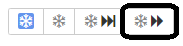

## 1. 実験用リポジトリの作成、リポジトリ名の入力、実験の入力データの設定を行う

### - 1.1  実験用の空リポジトリを作成する

以下のリンクに遷移し、データガバナンス機能で実験用の空リポジトリを作成してください。  
※空のリポジトリを作成するために、「選択されたファイルおよびテンプレートでリポジトリを初期化」のチェックを外してください。  
 [データガバナンス機能に遷移する](http://dg02.dg.rcos.nii.ac.jp/repo/create)

### - 1.2 作成したリポジトリ名を入力する

以下のセルを実行してリポジトリ名を入力してください。  
※もし入力値に誤りがあった場合、もう一度実行することで訂正ができます。

In [ ]:
from IPython.display import clear_output
repository_title = input("リポジトリ名")
clear_output()
print("作成したリポジトリ名；",repository_title)

### - 1.3 この実験の入力データを既存の実験の出力データからコピーしたい場合は以下を実行する

以下のセルを実行して、この実験の入力データとしたい出力データを持つ既存実験のリポジトリをセレクトボックスから選択してください。  
※入力データのコピーが不要であれば、1.3をスキップして2.に進んでください。

In [ ]:
from ipywidgets import Select, Button
from IPython.display import clear_output

# 実験リポジトリ名を取得する
import os
path = '/home/jovyan/experiments'
files = os.listdir(path)
files_dir = [f for f in files if os.path.isdir(os.path.join(path, f)) and f != '.ipynb_checkpoints']

# セレクトボックスで選択された実験リポジトリ名をex_repoに格納する
def on_click_callback(clicked_button: Button) -> None:
    global ex_repo
    ex_repo = select.value

button = Button(description='選択完了')
select = Select(options=files_dir)
button.on_click(on_click_callback)
display(select, button)

## 2. 実験環境を整える

In [ ]:
################################################################################
####################　桑田追加分（検証中）　####################################
################################################################################

# GIN APIでリポジトリを作成する
import requests

create_repo = requests.post(
                # FIXME: ドメイン名のハードコーディング
                'http://dg02.dg.rcos.nii.ac.jp/api/v1/user/repos?token=' + os.environ['CURRENT_USER'],
                data={
                    "name": repository_title,
                    "auto_init": True,
                    "readme": "Default"
                }
                )
print(create_repo)

### - 2.1 実験リポジトリのリモートURLを生成する

◆◆◆開発メモ◆◆◆  
リポジトリ作成をGIN APIを利用する方式にしたことで修正が必要かもしれない

In [ ]:
%cd ~/
tmp = !git remote -v
tmp = tmp[0]
tmp = tmp[tmp.find("http"):]
tmp = tmp.split("/")
tmp = tmp[0] + "//" + tmp[2] + "/" + tmp[3]

remote_url = tmp + "/" + repository_title + ".git"

### - 2.2 空リポジトリ名のフォルダを作成し、実験パッケージをコピーする

In [ ]:
!mkdir ~/.tmp/
!git init ~/.tmp/$repository_title
# !datalad create ~/.tmp/$repository_title
!cp -r ~/WORKFLOW/PACKAGE/. ~/.tmp/$repository_title/
# ex_repoが存在するなら、既存の実験の出力データをinput_dataにコピーする
try:
    ex_repo
    %cd /home/jovyan/experiments/$ex_repo
    !git pull
    %cd ~/
    !cp -r ~/experiments/$ex_repo/output_data/. ~/.tmp/$repository_title/input_data/
except:
    pass
%cd ~/.tmp/$repository_title
!git add ~/.tmp/$repository_title
!git commit -m '1st commit'
!git remote add $repository_title $remote_url
!git push $repository_title master
# !datalad save --to-git -m "1st commit"
# !datalad push

### - 2.3 上記リポジトリをサブデータセットとして設定する

In [ ]:
%cd ~/
!git submodule add $remote_url ./experiments/$repository_title

### - 2.4. pipeline.jsonに実験名を追記する

In [ ]:
import json

with open('/home/jovyan/experiments/pipeline.json', 'r') as f:
    pipeline = json.load(f)

pipeline.append(repository_title)

with open('/home/jovyan/experiments/pipeline.json', 'w') as f:
    json.dump(pipeline, f, indent = 4)

### - 2.5 このノートブックを保存する

In [ ]:
from IPython.display import display, Javascript
display(Javascript('IPython.notebook.save_checkpoint();'))

### - 2.6 実行結果をデータガバナンス機能に反映する

In [ ]:
# %cd ~/
# !git add ~/
# !git commit -m '実験の作成'
# !git push origin master
# # !datalad save --to-git -m "実験の作成"
# # !datalad push

In [ ]:
import papermill as pm

pm.execute_notebook(
    '../util/datalad_save_push.ipynb',
    '-',
    parameters = dict(SAVE_MESSAGE = '実験用リポジトリの作成', PATH = [未定])
)

## 3. 実験リポジトリにアクセスして実験を開始する

以下のセルを実行した後に出力されるリンクをクリックして実験に移ってください。  
このリンクはデータガバナンス機能に作成した実験リポジトリのトップ画面にも表示されます。  

In [ ]:
import urllib

print(
    "https://binder.cs.rcos.nii.ac.jp/v2/git/" + urllib.parse.quote(remote_url, safe='') + "/HEAD?filepath=experiment.ipynb"
)

## 4.[FLOW](../FLOW.md)に戻る